In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
WHITEN = True

## Data

In [3]:
import os
from pathlib import Path

data_dir = Path('./data/')
data_path = Path('./data/mnist.npz')

if not data_path.is_file():
    if not data_dir.is_dir():
        os.mkdir(data_dir)
    from keras.datasets import mnist
    (X_training, Y_training), (X_test, Y_test) = mnist.load_data()
    np.savez(data_path, X_training, Y_training, X_test, Y_test)

dataset = np.load(data_path)

X_training, Y_training, X_test, Y_test = torch.tensor(dataset['arr_0']/255., dtype=torch.float32).reshape(-1, 784), torch.tensor(2. * dataset['arr_1'] - 1., dtype=torch.float32).reshape(-1, 1), torch.tensor(dataset['arr_2']/255., dtype=torch.float32).reshape(-1, 784), torch.tensor(2. * dataset['arr_3'] -1., dtype=torch.float32).reshape(-1, 1)
X_training.shape, Y_training.shape, X_test.shape, Y_test.shape

(torch.Size([60000, 784]),
 torch.Size([60000, 1]),
 torch.Size([10000, 784]),
 torch.Size([10000, 1]))

In [4]:
X_training_01 = X_training[Y_training.squeeze() < 2]
Y_training_01 = Y_training[Y_training.squeeze() < 2]
X_training_01.shape, Y_training_01.shape

(torch.Size([12665, 784]), torch.Size([12665, 1]))

In [5]:
if WHITEN:
    from sklearn.decomposition import PCA
    whiten = PCA(whiten=True)

    X_training_whitened = torch.tensor(whiten.fit_transform(X_training_01), dtype=torch.float32)
    print(X_training_whitened.shape)

torch.Size([12665, 784])


In [6]:
from sklearn.model_selection import train_test_split

X_train_val, X_dummy, Y_train_val, Y_dummy = train_test_split(X_training_whitened if WHITEN else X_training_01, Y_training_01, train_size=2000)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, train_size=1000)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([1000, 784]),
 torch.Size([1000, 784]),
 torch.Size([1000, 1]),
 torch.Size([1000, 1]))

In [7]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, 8, True), make_dataloader(X_val, Y_val, 8, True)

## NN

In [8]:
device = 'cpu'

In [9]:
from scripts.models import SimpleNN
from scripts.train import train_model
from scripts.metrics import NegMeanSquaredError

In [10]:
model_nn = SimpleNN(784, task_type='regression', hidden_layers=1, hidden_units=100).to(device)

In [11]:
model_nn_init = model_nn.clone()

In [12]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(params=model_nn.parameters(), lr=5e-3)
metric = NegMeanSquaredError()

In [13]:
history = train_model(
    model=model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    device=device
)

Training model for 500 epochs. Early stopping not enabled.
Epoch: 1 => Train loss: 0.876710, Train score: -0.876710, Val loss: 0.751068, Val score: -0.751068
Epoch: 2 => Train loss: 0.551180, Train score: -0.551180, Val loss: 0.643819, Val score: -0.643819
Epoch: 3 => Train loss: 0.406933, Train score: -0.406933, Val loss: 0.521482, Val score: -0.521482
Epoch: 4 => Train loss: 0.306977, Train score: -0.306977, Val loss: 0.479391, Val score: -0.479391
Epoch: 5 => Train loss: 0.168890, Train score: -0.168890, Val loss: 0.534220, Val score: -0.534220
Epoch: 6 => Train loss: 0.053719, Train score: -0.053719, Val loss: 0.444312, Val score: -0.444312
Epoch: 7 => Train loss: 0.040117, Train score: -0.040117, Val loss: 0.466409, Val score: -0.466409
Epoch: 8 => Train loss: 0.033081, Train score: -0.033081, Val loss: 0.435757, Val score: -0.435757
Epoch: 9 => Train loss: 0.028280, Train score: -0.028280, Val loss: 0.452365, Val score: -0.452365
Epoch: 10 => Train loss: 0.016881, Train score: -0

In [14]:
model_nn_final = model_nn.clone()

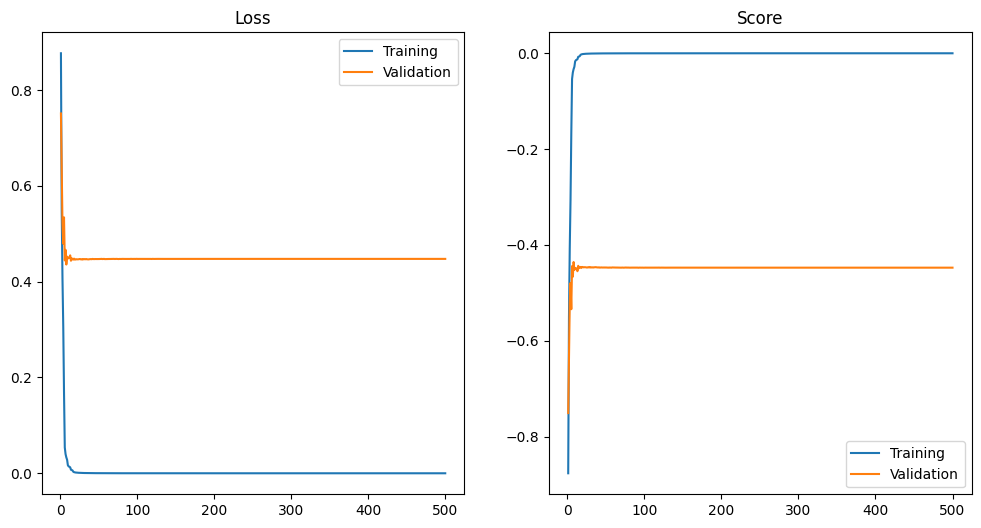

In [15]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [16]:
from scripts.test import predict

preds_train_nn, preds_val_nn = predict(model_nn, X_train, device), predict(model_nn, X_val, device)

In [17]:
score_train, score_val = metric(preds_train_nn, Y_train.squeeze()), metric(preds_val_nn, Y_val.squeeze())
score_train, score_val

(tensor(-6.9849e-08), tensor(-0.4475))

## SVM with NTK

In [18]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from scripts.ntk import NTK

In [19]:
params = {
    'C': np.logspace(-5, 5, 11)
}
scorer = make_scorer(mean_squared_error, greater_is_better=False)

### T = 0

In [20]:
ntk_init = NTK(model_nn_init).get_ntk

In [21]:
model_km_init_base = SVR(kernel=ntk_init)

In [22]:
model_km_init = GridSearchCV(
    estimator=model_km_init_base,
    param_grid=params,
    scoring=scorer,
    n_jobs=5,
    verbose=3
)
model_km_init.fit(X_train, Y_train.squeeze())
model_km_init.best_params_

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END ..........................C=1e-05;, score=-1.600 total time=   2.3s
[CV 3/5] END ..........................C=1e-05;, score=-1.906 total time=   2.3s
[CV 5/5] END ..........................C=1e-05;, score=-1.619 total time=   2.5s
[CV 4/5] END ..........................C=1e-05;, score=-1.602 total time=   2.6s
[CV 2/5] END ..........................C=1e-05;, score=-1.584 total time=   2.7s
[CV 1/5] END .........................C=0.0001;, score=-1.501 total time=   2.5s
[CV 2/5] END .........................C=0.0001;, score=-1.493 total time=   2.6s
[CV 3/5] END .........................C=0.0001;, score=-1.802 total time=   2.4s
[CV 5/5] END .........................C=0.0001;, score=-1.525 total time=   2.4s
[CV 4/5] END .........................C=0.0001;, score=-1.511 total time=   2.6s
[CV 1/5] END ..........................C=0.001;, score=-0.936 total time=   2.2s
[CV 2/5] END ..........................C=0.001;,

{'C': 0.1}

In [23]:
preds_train_km_init, preds_val_km_init = model_km_init.predict(X_train), model_km_init.predict(X_val)

In [24]:
score_train, score_val = mean_squared_error(Y_train.squeeze(), preds_train_km_init), mean_squared_error(Y_val.squeeze(), preds_val_km_init)
score_train, score_val

(0.008531136628629572, 0.6051286338953966)

### T = inf

In [25]:
ntk_final = NTK(model_nn_final).get_ntk

In [26]:
model_km_final_base = SVR(kernel=ntk_final)

In [27]:
model_km_final = GridSearchCV(
    estimator=model_km_final_base,
    param_grid=params,
    scoring=scorer,
    n_jobs=5,
    verbose=3
)
model_km_final.fit(X_train, Y_train.squeeze())
model_km_final.best_params_

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 3/5] END ..........................C=1e-05;, score=-1.872 total time=   3.3s
[CV 1/5] END ..........................C=1e-05;, score=-1.571 total time=   3.3s
[CV 5/5] END ..........................C=1e-05;, score=-1.589 total time=   3.5s
[CV 2/5] END ..........................C=1e-05;, score=-1.554 total time=   3.6s
[CV 4/5] END ..........................C=1e-05;, score=-1.572 total time=   3.6s
[CV 2/5] END .........................C=0.0001;, score=-1.219 total time=   2.9s
[CV 4/5] END .........................C=0.0001;, score=-1.234 total time=   3.1s
[CV 1/5] END .........................C=0.0001;, score=-1.226 total time=   3.5s
[CV 3/5] END .........................C=0.0001;, score=-1.484 total time=   3.7s
[CV 5/5] END .........................C=0.0001;, score=-1.242 total time=   3.6s
[CV 1/5] END ..........................C=0.001;, score=-0.069 total time=   3.3s
[CV 3/5] END ..........................C=0.001;,

{'C': 0.01}

In [28]:
preds_train_km_final, preds_val_km_final = model_km_final.predict(X_train), model_km_final.predict(X_val)

In [29]:
score_train, score_val = mean_squared_error(Y_train.squeeze(), preds_train_km_final), mean_squared_error(Y_val.squeeze(), preds_val_km_final)
score_train, score_val

(0.009208496992091864, 0.336167880674683)

## Comparison

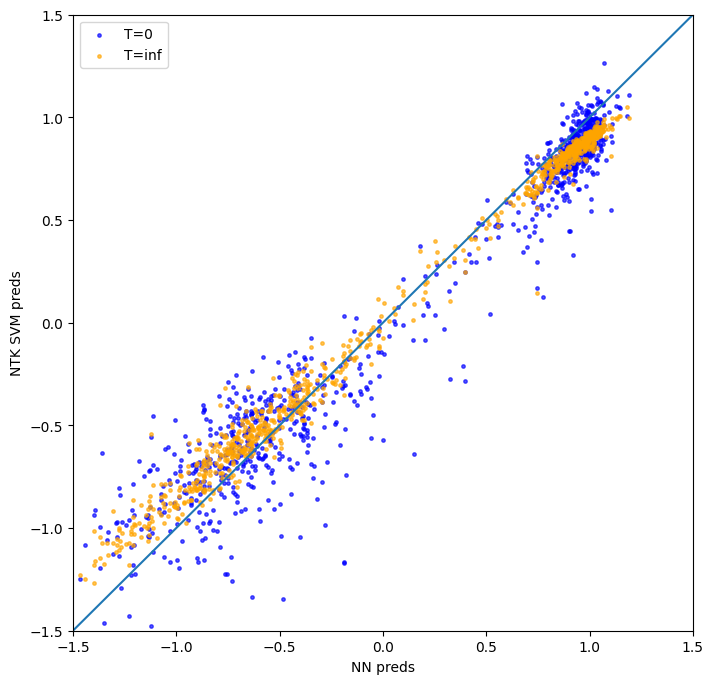

In [30]:
plt.figure(figsize=(8, 8))

plt.plot(np.arange(-1.5, 1.55, 0.05), np.arange(-1.5, 1.55, 0.05))
plt.scatter(preds_val_nn, preds_val_km_init, c='blue', s=6, label=f'T=0', alpha=0.65)
plt.scatter(preds_val_nn, preds_val_km_final, c='orange', s=6, label=f'T=inf', alpha=0.65)
plt.xlabel('NN preds')
plt.ylabel('NTK SVM preds')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()

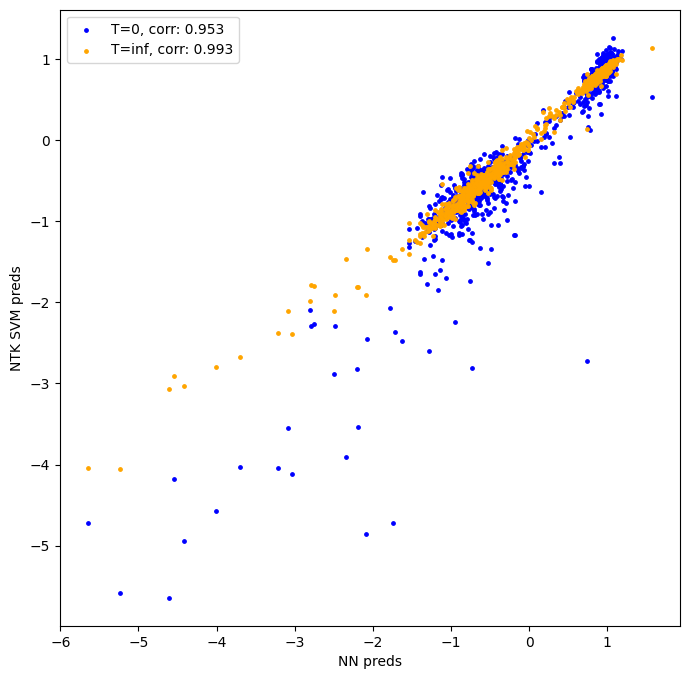

In [31]:
from scripts.utils import plot_ntk_corrs

plot_ntk_corrs(preds_val_nn, preds_val_km_init, preds_val_km_final)